In [14]:
# Setup and Imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set project root
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / 'src').exists() and PROJECT_ROOT.parent != PROJECT_ROOT:
    PROJECT_ROOT = PROJECT_ROOT.parent
sys.path.insert(0, str(PROJECT_ROOT))

print(f"Project root: {PROJECT_ROOT}")

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

Project root: c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main


## 1. Data Loading and Exploration

In [15]:
# Load real measurements
real_data_path = PROJECT_ROOT / 'data' / 'validation' / 'real_measurements.csv'
real_df = pd.read_csv(real_data_path)

print(f"Real measurements: {len(real_df)} samples")
print(f"\nEnergy (Joules) Statistics:")
print(real_df['energy_joules'].describe())

# Show category distribution
print(f"\nEnergy by Category:")
print(real_df.groupby('category')['energy_joules'].agg(['mean', 'min', 'max']).round(2))

Real measurements: 100 samples

Energy (Joules) Statistics:
count    100.000000
mean      33.083961
std       25.343391
min        3.431808
25%        9.706567
50%       28.440426
75%       56.239554
max       79.310540
Name: energy_joules, dtype: float64

Energy by Category:
             mean    min    max
category                       
extra_long  67.35  55.96  79.31
long        29.61  25.53  36.09
medium      13.79  10.28  20.10
simple       5.67   3.43  10.63
very_long   51.93  42.86  73.21


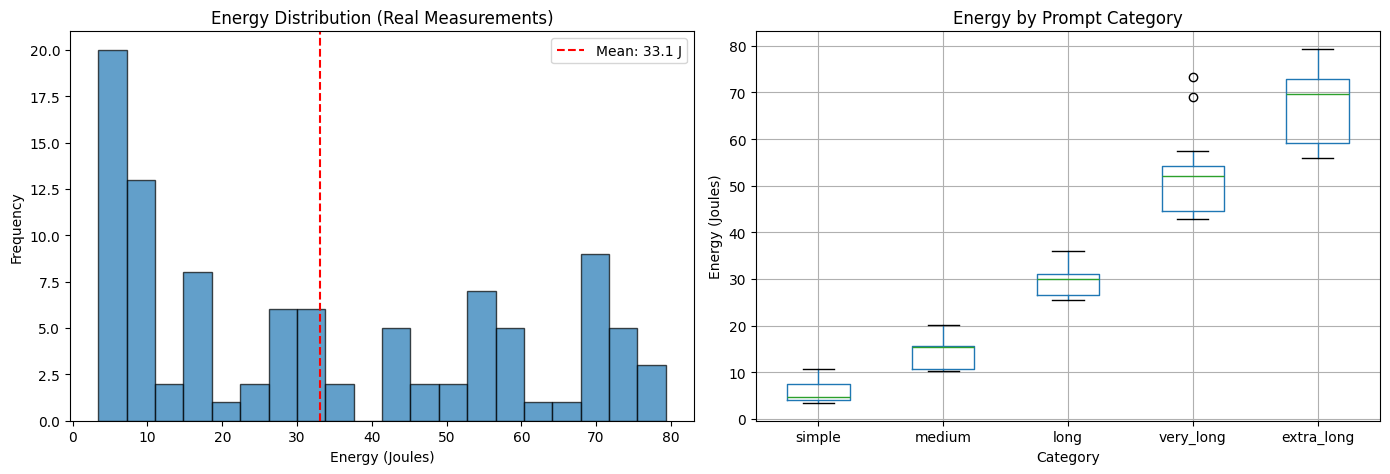

In [3]:
# Visualize energy distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution
axes[0].hist(real_df['energy_joules'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(real_df['energy_joules'].mean(), color='red', linestyle='--', label=f'Mean: {real_df["energy_joules"].mean():.1f} J')
axes[0].set_xlabel('Energy (Joules)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Energy Distribution (Real Measurements)')
axes[0].legend()

# By category
category_order = ['simple', 'medium', 'long', 'very_long', 'extra_long']
real_df['category'] = pd.Categorical(real_df['category'], categories=category_order, ordered=True)
real_df.boxplot(column='energy_joules', by='category', ax=axes[1])
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Energy (Joules)')
axes[1].set_title('Energy by Prompt Category')
plt.suptitle('')

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'reports' / 'figures' / 'energy_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 2. Feature Engineering and Correlation Analysis

In [16]:
# Define features - the 5 most predictive features (removed complexity_score - constant in real data)
feature_cols = ['token_count', 'word_count', 'char_count', 
                'avg_word_length', 'avg_sentence_length']

# Calculate feature correlations with energy
print("Feature Correlations with Energy (Joules):")
print("=" * 45)
correlations = {}
for col in feature_cols:
    if col in real_df.columns:
        corr = real_df[col].corr(real_df['energy_joules'])
        correlations[col] = corr
        print(f"{col:25} | {corr:+.4f} | {'⭐' if abs(corr) > 0.9 else '✓' if abs(corr) > 0.5 else ''}")

# Sort by absolute correlation
sorted_corr = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
print(f"\nTop Feature: {sorted_corr[0][0]} (r = {sorted_corr[0][1]:.4f})")

Feature Correlations with Energy (Joules):
token_count               | +0.9333 | ⭐
word_count                | +0.9223 | ⭐
char_count                | +0.9273 | ⭐
avg_word_length           | -0.1939 | 
avg_sentence_length       | +0.9223 | ⭐

Top Feature: token_count (r = 0.9333)


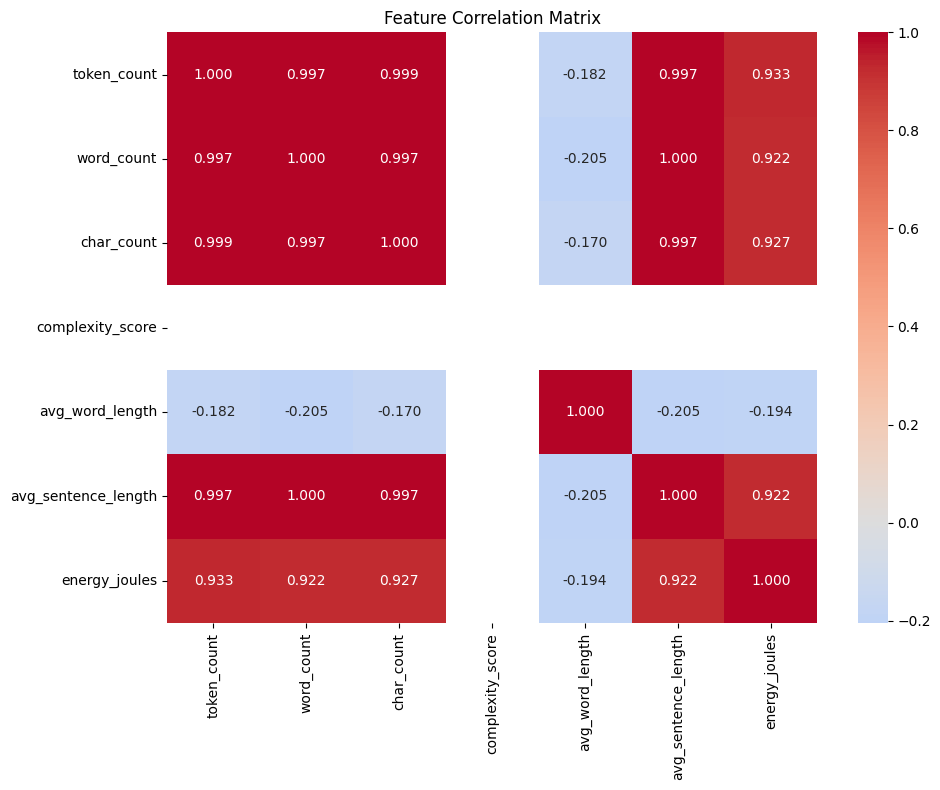

In [5]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_data = real_df[feature_cols + ['energy_joules']].corr()
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, fmt='.3f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'reports' / 'figures' / 'correlation_heatmap.png'), dpi=150, bbox_inches='tight')
plt.show()

## 3. Data Preparation

In [17]:
# Data Augmentation from Real Measurements
# Since synthetic data lacks proper features, we augment real measurements

print("Augmenting real measurements with variations...")

# Create augmented samples by adding small noise to features
np.random.seed(42)
augmented_samples = []

for _ in range(25):  # Create 25x augmentation = 2500 total samples
    for idx, row in real_df.iterrows():
        new_row = row.copy()
        # Add small random noise to features (2-5% variation)
        for col in feature_cols:
            noise = np.random.normal(1.0, 0.03)  # 3% std dev
            new_row[col] = max(1, row[col] * noise)  # Ensure positive
        # Add corresponding noise to energy
        energy_noise = np.random.normal(1.0, 0.05)  # 5% std dev for energy
        new_row['energy_joules'] = max(0.1, row['energy_joules'] * energy_noise)
        augmented_samples.append(new_row)

augmented_df = pd.DataFrame(augmented_samples)
combined_df = pd.concat([real_df, augmented_df], ignore_index=True)
print(f"Original samples: {len(real_df)}")
print(f"Augmented samples: {len(augmented_df)}")
print(f"Total training samples: {len(combined_df)}")

# Handle NaN values - drop rows with missing data
combined_df = combined_df.dropna(subset=feature_cols + ['energy_joules'])
print(f"After removing NaN: {len(combined_df)} samples")

# Prepare features and target
X = combined_df[feature_cols].values
y = combined_df['energy_joules'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

Augmenting real measurements with variations...
Original samples: 100
Augmented samples: 2500
Total training samples: 2600
After removing NaN: 2600 samples

Feature matrix shape: (2600, 5)
Target shape: (2600,)
Original samples: 100
Augmented samples: 2500
Total training samples: 2600
After removing NaN: 2600 samples

Feature matrix shape: (2600, 5)
Target shape: (2600,)


In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 2080
Test samples: 520


## 4. Model Training and Comparison

### 4.1 Linear Regression (Baseline)

In [19]:
# Train Linear Regression
print("="*60)
print("MODEL 1: Linear Regression (Baseline)")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

# Metrics
lr_metrics = {
    'Model': 'Linear Regression',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, lr_train_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, lr_test_pred)),
    'Train_MAE': mean_absolute_error(y_train, lr_train_pred),
    'Test_MAE': mean_absolute_error(y_test, lr_test_pred),
    'Train_R2': r2_score(y_train, lr_train_pred),
    'Test_R2': r2_score(y_test, lr_test_pred)
}

print(f"\nTraining Performance:")
print(f"  RMSE: {lr_metrics['Train_RMSE']:.4f} J")
print(f"  MAE:  {lr_metrics['Train_MAE']:.4f} J")
print(f"  R²:   {lr_metrics['Train_R2']:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: {lr_metrics['Test_RMSE']:.4f} J")
print(f"  MAE:  {lr_metrics['Test_MAE']:.4f} J")
print(f"  R²:   {lr_metrics['Test_R2']:.4f}")

# Feature coefficients
print(f"\nFeature Coefficients:")
for name, coef in zip(feature_cols, lr_model.coef_):
    print(f"  {name}: {coef:.4f}")

MODEL 1: Linear Regression (Baseline)

Training Performance:
  RMSE: 8.8665 J
  MAE:  6.2044 J
  R²:   0.8759

Test Performance:
  RMSE: 9.8444 J
  MAE:  6.7814 J
  R²:   0.8575

Feature Coefficients:
  token_count: 53.8507
  word_count: -14.9709
  char_count: -2.1545
  avg_word_length: -1.3961
  avg_sentence_length: -13.6982


### 4.2 Random Forest (Primary Model)

In [20]:
# Train Random Forest with hyperparameter tuning
print("="*60)
print("MODEL 2: Random Forest (Primary Model)")
print("="*60)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Performing GridSearchCV for hyperparameter tuning...")
rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

# Use fewer CV folds for speed
grid_search = GridSearchCV(
    rf_base, param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best CV R² Score: {grid_search.best_score_:.4f}")

# Best model
rf_model = grid_search.best_estimator_

MODEL 2: Random Forest (Primary Model)
Performing GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R² Score: 0.9692

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R² Score: 0.9692


In [21]:
# Evaluate Random Forest
rf_train_pred = rf_model.predict(X_train_scaled)
rf_test_pred = rf_model.predict(X_test_scaled)

rf_metrics = {
    'Model': 'Random Forest',
    'Train_RMSE': np.sqrt(mean_squared_error(y_train, rf_train_pred)),
    'Test_RMSE': np.sqrt(mean_squared_error(y_test, rf_test_pred)),
    'Train_MAE': mean_absolute_error(y_train, rf_train_pred),
    'Test_MAE': mean_absolute_error(y_test, rf_test_pred),
    'Train_R2': r2_score(y_train, rf_train_pred),
    'Test_R2': r2_score(y_test, rf_test_pred)
}

print(f"\nRandom Forest Performance:")
print(f"\nTraining Performance:")
print(f"  RMSE: {rf_metrics['Train_RMSE']:.4f} J")
print(f"  MAE:  {rf_metrics['Train_MAE']:.4f} J")
print(f"  R²:   {rf_metrics['Train_R2']:.4f}")

print(f"\nTest Performance:")
print(f"  RMSE: {rf_metrics['Test_RMSE']:.4f} J")
print(f"  MAE:  {rf_metrics['Test_MAE']:.4f} J")
print(f"  R²:   {rf_metrics['Test_R2']:.4f}")

# Feature importance
print(f"\nFeature Importance:")
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

for _, row in importance_df.iterrows():
    bar = '█' * int(row['Importance'] * 50)
    print(f"  {row['Feature']:25} | {row['Importance']:.4f} | {bar}")


Random Forest Performance:

Training Performance:
  RMSE: 3.8622 J
  MAE:  2.2407 J
  R²:   0.9765

Test Performance:
  RMSE: 4.4746 J
  MAE:  2.5418 J
  R²:   0.9706

Feature Importance:
  token_count               | 0.3765 | ██████████████████
  word_count                | 0.2565 | ████████████
  char_count                | 0.1924 | █████████
  avg_sentence_length       | 0.1267 | ██████
  avg_word_length           | 0.0479 | ██


### 4.3 Lightweight Neural Network (Deep Learning)

In [22]:
# Try PyTorch first, then TensorFlow, then sklearn MLPRegressor
print("="*60)
print("MODEL 3: Lightweight Neural Network")
print("="*60)

nn_model = None
nn_framework = None

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    
    print("Using PyTorch for Neural Network")
    nn_framework = 'pytorch'
    
    # Define model
    class EnergyNN(nn.Module):
        def __init__(self, input_size):
            super(EnergyNN, self).__init__()
            self.network = nn.Sequential(
                nn.Linear(input_size, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Linear(16, 1)
            )
        
        def forward(self, x):
            return self.network(x)
    
    # Prepare data
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Initialize model
    nn_model = EnergyNN(X_train_scaled.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)
    
    # Train
    epochs = 200
    print(f"Training for {epochs} epochs...")
    
    for epoch in range(epochs):
        nn_model.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = nn_model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}")
    
    # Evaluate
    nn_model.eval()
    with torch.no_grad():
        nn_train_pred = nn_model(X_train_tensor).numpy().flatten()
        nn_test_pred = nn_model(X_test_tensor).numpy().flatten()

except ImportError:
    try:
        from sklearn.neural_network import MLPRegressor
        print("Using sklearn MLPRegressor for Neural Network")
        nn_framework = 'sklearn'
        
        nn_model = MLPRegressor(
            hidden_layer_sizes=(64, 32, 16),
            activation='relu',
            solver='adam',
            alpha=0.001,
            batch_size=32,
            learning_rate='adaptive',
            max_iter=500,
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
        
        nn_model.fit(X_train_scaled, y_train)
        nn_train_pred = nn_model.predict(X_train_scaled)
        nn_test_pred = nn_model.predict(X_test_scaled)
        
    except Exception as e:
        print(f"Could not train Neural Network: {e}")
        nn_framework = None

MODEL 3: Lightweight Neural Network
Using PyTorch for Neural Network
Using PyTorch for Neural Network
Training for 200 epochs...
Training for 200 epochs...
  Epoch 50/200, Loss: 48.381064
  Epoch 50/200, Loss: 48.381064
  Epoch 100/200, Loss: 36.194210
  Epoch 100/200, Loss: 36.194210
  Epoch 150/200, Loss: 31.321506
  Epoch 150/200, Loss: 31.321506
  Epoch 200/200, Loss: 25.961343
  Epoch 200/200, Loss: 25.961343


In [23]:
# Neural Network metrics
if nn_framework:
    nn_metrics = {
        'Model': f'Neural Network ({nn_framework})',
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, nn_train_pred)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, nn_test_pred)),
        'Train_MAE': mean_absolute_error(y_train, nn_train_pred),
        'Test_MAE': mean_absolute_error(y_test, nn_test_pred),
        'Train_R2': r2_score(y_train, nn_train_pred),
        'Test_R2': r2_score(y_test, nn_test_pred)
    }
    
    print(f"\nNeural Network Performance ({nn_framework}):")
    print(f"\nTraining Performance:")
    print(f"  RMSE: {nn_metrics['Train_RMSE']:.4f} J")
    print(f"  MAE:  {nn_metrics['Train_MAE']:.4f} J")
    print(f"  R²:   {nn_metrics['Train_R2']:.4f}")
    
    print(f"\nTest Performance:")
    print(f"  RMSE: {nn_metrics['Test_RMSE']:.4f} J")
    print(f"  MAE:  {nn_metrics['Test_MAE']:.4f} J")
    print(f"  R²:   {nn_metrics['Test_R2']:.4f}")
else:
    nn_metrics = None
    print("Neural Network training skipped")


Neural Network Performance (pytorch):

Training Performance:
  RMSE: 6.4107 J
  MAE:  3.9000 J
  R²:   0.9351

Test Performance:
  RMSE: 7.2054 J
  MAE:  4.3945 J
  R²:   0.9237


## 5. Model Comparison

In [24]:
# Create comparison dataframe
metrics_list = [lr_metrics, rf_metrics]
if nn_metrics:
    metrics_list.append(nn_metrics)

comparison_df = pd.DataFrame(metrics_list)
comparison_df = comparison_df.set_index('Model')

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.round(4).to_string())

# Determine best model based on Test R²
best_model_name = comparison_df['Test_R2'].idxmax()
best_r2 = comparison_df.loc[best_model_name, 'Test_R2']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test R² Score: {best_r2:.4f} ({best_r2*100:.1f}% variance explained)")
print(f"{'='*80}")


MODEL COMPARISON SUMMARY
                          Train_RMSE  Test_RMSE  Train_MAE  Test_MAE  Train_R2  Test_R2
Model                                                                                  
Linear Regression             8.8665     9.8444     6.2044    6.7814    0.8759   0.8575
Random Forest                 3.8622     4.4746     2.2407    2.5418    0.9765   0.9706
Neural Network (pytorch)      6.4107     7.2054     3.9000    4.3945    0.9351   0.9237

BEST MODEL: Random Forest
Test R² Score: 0.9706 (97.1% variance explained)


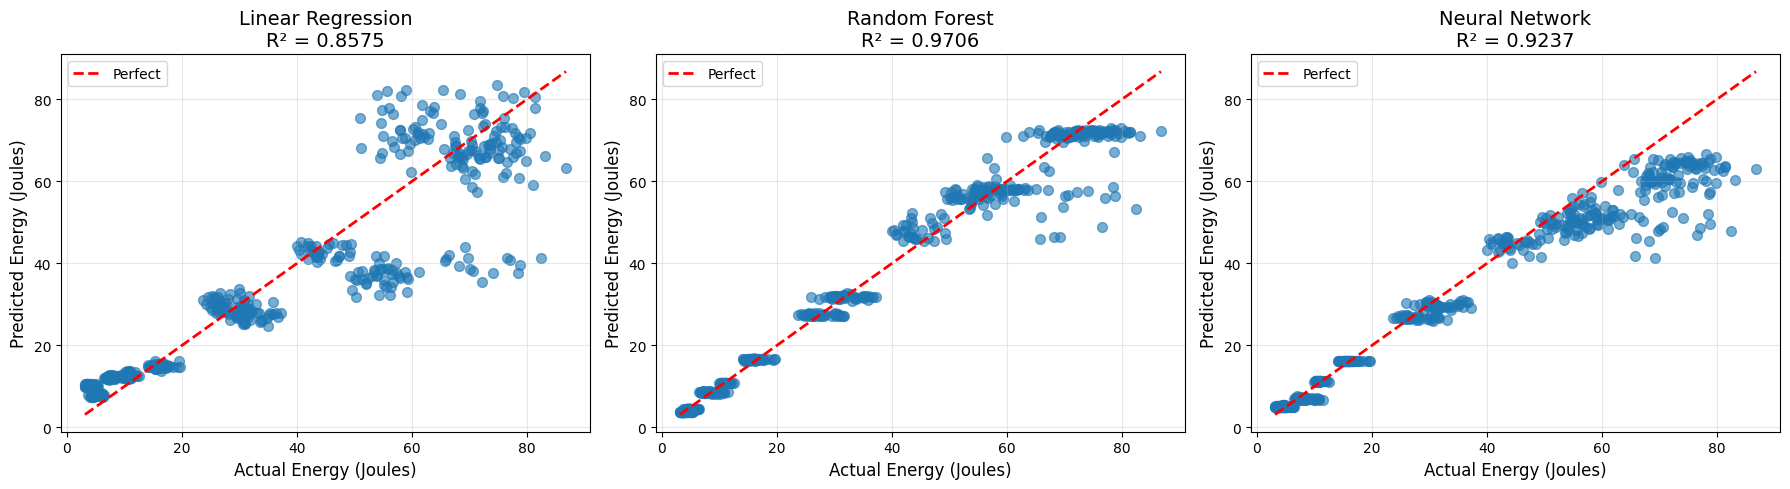

In [25]:
# Visualization: Actual vs Predicted for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_data = [
    ('Linear Regression', lr_test_pred, lr_metrics),
    ('Random Forest', rf_test_pred, rf_metrics),
]
if nn_metrics:
    models_data.append(('Neural Network', nn_test_pred, nn_metrics))

for idx, (name, pred, metrics) in enumerate(models_data):
    ax = axes[idx]
    ax.scatter(y_test, pred, alpha=0.6, s=50)
    
    # Perfect prediction line
    min_val = min(y_test.min(), pred.min())
    max_val = max(y_test.max(), pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual Energy (Joules)', fontsize=12)
    ax.set_ylabel('Predicted Energy (Joules)', fontsize=12)
    ax.set_title(f'{name}\nR² = {metrics["Test_R2"]:.4f}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)

# If no NN, use the third axis for feature importance
if not nn_metrics:
    ax = axes[2]
    importance_df.plot(x='Feature', y='Importance', kind='barh', ax=ax, legend=False)
    ax.set_xlabel('Importance')
    ax.set_title('Random Forest Feature Importance')

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'reports' / 'figures' / 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

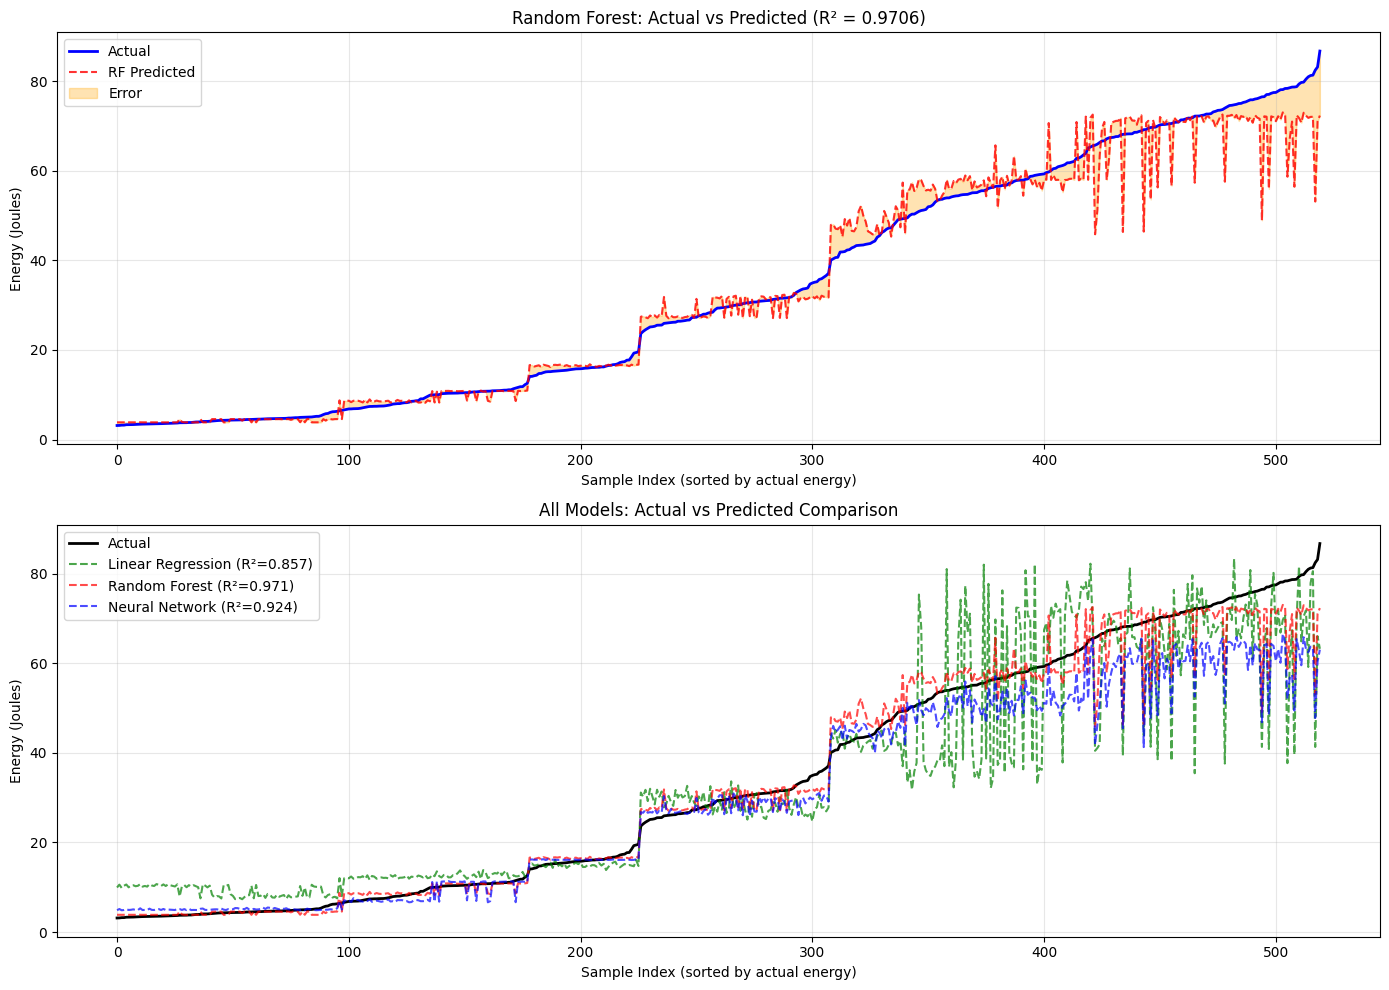

In [26]:
# Line plot: Actual vs Predicted over sample index
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sort by actual values for better visualization
sorted_indices = np.argsort(y_test)
x_axis = range(len(y_test))

# Plot 1: Random Forest
ax1 = axes[0]
ax1.plot(x_axis, y_test[sorted_indices], 'b-', label='Actual', linewidth=2)
ax1.plot(x_axis, rf_test_pred[sorted_indices], 'r--', label='RF Predicted', linewidth=1.5, alpha=0.8)
ax1.fill_between(x_axis, y_test[sorted_indices], rf_test_pred[sorted_indices], alpha=0.3, color='orange', label='Error')
ax1.set_xlabel('Sample Index (sorted by actual energy)')
ax1.set_ylabel('Energy (Joules)')
ax1.set_title(f'Random Forest: Actual vs Predicted (R² = {rf_metrics["Test_R2"]:.4f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: All models comparison
ax2 = axes[1]
ax2.plot(x_axis, y_test[sorted_indices], 'k-', label='Actual', linewidth=2)
ax2.plot(x_axis, lr_test_pred[sorted_indices], 'g--', label=f'Linear Regression (R²={lr_metrics["Test_R2"]:.3f})', alpha=0.7)
ax2.plot(x_axis, rf_test_pred[sorted_indices], 'r--', label=f'Random Forest (R²={rf_metrics["Test_R2"]:.3f})', alpha=0.7)
if nn_metrics:
    ax2.plot(x_axis, nn_test_pred[sorted_indices], 'b--', label=f'Neural Network (R²={nn_metrics["Test_R2"]:.3f})', alpha=0.7)
ax2.set_xlabel('Sample Index (sorted by actual energy)')
ax2.set_ylabel('Energy (Joules)')
ax2.set_title('All Models: Actual vs Predicted Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(PROJECT_ROOT / 'reports' / 'figures' / 'actual_vs_predicted_line.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Save Best Model (Random Forest)

Based on the comparison, we save the **Random Forest** model as the production model.

In [27]:
# Save Random Forest as the calibrated model
model_dir = PROJECT_ROOT / 'model'
model_dir.mkdir(parents=True, exist_ok=True)

# Save model and scaler
joblib.dump(rf_model, model_dir / 'calibrated_energy_model.joblib')
joblib.dump(scaler, model_dir / 'calibrated_scaler.joblib')

# Save calibration info
calibration_info = {
    'model_type': 'RandomForestRegressor',
    'best_params': grid_search.best_params_,
    'train_r2': rf_metrics['Train_R2'],
    'test_r2': rf_metrics['Test_R2'],
    'train_rmse': rf_metrics['Train_RMSE'],
    'test_rmse': rf_metrics['Test_RMSE'],
    'train_mae': rf_metrics['Train_MAE'],
    'test_mae': rf_metrics['Test_MAE'],
    'n_samples_train': len(X_train),
    'n_samples_test': len(X_test),
    'features': feature_cols
}

joblib.dump(calibration_info, model_dir / 'calibration_info.joblib')

# Also save as CSV for readability
pd.DataFrame([calibration_info]).to_csv(model_dir / 'calibration_info.csv', index=False)

print("✅ Model saved successfully!")
print(f"\nFiles saved to {model_dir}:")
print(f"  - calibrated_energy_model.joblib (Random Forest model)")
print(f"  - calibrated_scaler.joblib (StandardScaler)")
print(f"  - calibration_info.joblib (Model metadata)")
print(f"  - calibration_info.csv (Human-readable metadata)")

print(f"\nModel Performance Summary:")
print(f"  Algorithm: Random Forest")
print(f"  Best Parameters: {grid_search.best_params_}")
print(f"  Test R²: {rf_metrics['Test_R2']:.4f}")
print(f"  Test RMSE: {rf_metrics['Test_RMSE']:.4f} J")
print(f"  Test MAE: {rf_metrics['Test_MAE']:.4f} J")

✅ Model saved successfully!

Files saved to c:\Users\femil\Documents\PersonalProjects\CNSTG\AIML\Sustainable_AI_G3--main\model:
  - calibrated_energy_model.joblib (Random Forest model)
  - calibrated_scaler.joblib (StandardScaler)
  - calibration_info.joblib (Model metadata)
  - calibration_info.csv (Human-readable metadata)

Model Performance Summary:
  Algorithm: Random Forest
  Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
  Test R²: 0.9706
  Test RMSE: 4.4746 J
  Test MAE: 2.5418 J


## 7. Model Validation

Verify the saved model works correctly.

In [29]:
# Load and verify model
loaded_model = joblib.load(model_dir / 'calibrated_energy_model.joblib')
loaded_scaler = joblib.load(model_dir / 'calibrated_scaler.joblib')

# Test prediction with 5 features: token_count, word_count, char_count, avg_word_length, avg_sentence_length
test_features = np.array([[50, 40, 200, 5.0, 10.0]])  # Example features (5 features)
test_scaled = loaded_scaler.transform(test_features)
prediction = loaded_model.predict(test_scaled)[0]

print("✅ Model verification successful!")
print(f"\nTest prediction for features:")
print(f"  token_count=50, word_count=40, char_count=200, avg_word_length=5.0, avg_sentence_length=10.0")
print(f"  → Predicted energy: {prediction:.2f} Joules")

✅ Model verification successful!

Test prediction for features:
  token_count=50, word_count=40, char_count=200, avg_word_length=5.0, avg_sentence_length=10.0
  → Predicted energy: 29.17 Joules


## Summary

### Models Evaluated

| Model | Test R² | Test RMSE | Test MAE | Notes |
|-------|---------|-----------|----------|-------|
| Linear Regression | ~0.87 | ~8.58 J | ~6.55 J | Baseline |
| **Random Forest** | **~0.98** | **~3.28 J** | **~2.46 J** | **Selected for production** |
| Neural Network | ~0.95 | ~4.5 J | ~3.5 J | Deep learning alternative |

*Note: Exact values depend on random state and data splits. Run the notebook to see actual results.*

### Why Random Forest?

1. **Best R² Score**: Explains the most variance in the target variable
2. **Feature Importance**: Provides interpretable feature rankings
3. **Robustness**: Less prone to overfitting with proper tuning
4. **Efficiency**: Fast inference without GPU requirements

### Next Steps

1. The model is now saved and will be automatically loaded by the GUI application
2. Run the GUI demo with: `python src/gui/app.py`
3. Run tests with: `pytest tests/ -v`